In [25]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


True


In [177]:
import numpy as np 
import argparse
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages, letterbox
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel
# test run
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def detect(source, weights, img_size, device, conf_thres, iou_thres, save_img=False, show_img = False, crop_img = False):
    device = select_device(device)
    
    half = device.type != 'cpu'  # half precision only supported on CUDA
    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(img_size, s=stride)  # check img_size
    
    if half:
        model.half()  # to FP16
         
    img0s= cv2.imread(source)  # BGR
    if show_img:
        img_result = img0s.copy()
    # Padded resize
    img = letterbox(img0s, imgsz, stride=stride)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)

    
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img)[0]

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres)

    # result outcome
    classes = []
    labels = []
    confidence_scores = []
    cropped_imgs = []
    
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], img0s.shape).round()
            
            # results
            for *xyxy, conf, cls in reversed(det):
                xyxy = torch.tensor(xyxy).view(1,4).view(-1).tolist()
                xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4))).view(-1).tolist()  # normalized xywh
                cls = int(cls.detach().cpu().numpy())
                conf = float(conf.detach().cpu().numpy())
                # result process
                classes.append(cls)
                labels.append(xywh)
                confidence_scores.append(conf)
                
                if show_img:
                    start = (int(xyxy[0]), int(xyxy[1]))
                    end = (int(xyxy[2]), int(xyxy[3]))
                    if cls == 0:
                        img_result = cv2.rectangle(img_result, start, end, (0,255,0), 2)
                    else:
                        img_result = cv2.rectangle(img_result, start, end, (255,0,0), 2)
                if crop_img:
                    cropped_im = img0s.copy()
                    x,y,w,h =[int(x) for x in xywh] # x center, y center, width, height
                    cropped_img = cropped_img = cropped_im[y-h//2: y + h//2, x-w//2: x + w//2, :]                
            
                    cropped_imgs.append(cropped_img)
    if show_img:
        plt.imshow(img_result)
    
    return {'out_class': classes, 'label': labels, 'score': confidence_scores, 'cropped_img': cropped_imgs}
                

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
[1, 0]
[[234.0, 782.5, 62.0, 33.0], [533.5, 768.0, 47.0, 66.0]]
[0.88916015625, 0.93701171875]


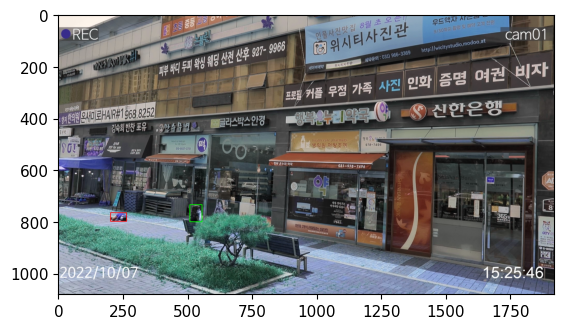

In [178]:
source = './sample_dataset/testing/000160.jpg' # source has to be framed img
weights = '/home/jinyong/yolov7/runs/train/yolov7_tl_epoch20/weights/epoch_005.pt'
img_size = 640
device = '0'
conf_thres = 0.25
iou_thres = 0.45

a = detect(source, weights, img_size, device, conf_thres, iou_thres, show_img = True, crop_img= True)
print(a['out_class'])
print(a['label'])
print(a['score'])

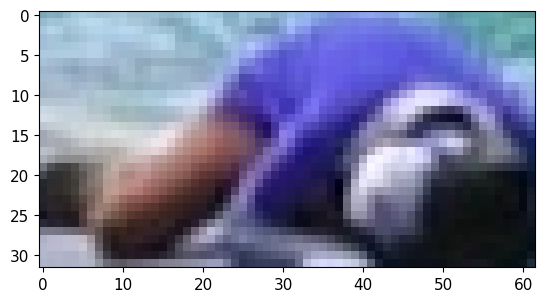

In [179]:
plt.imshow(a['cropped_img'][0])

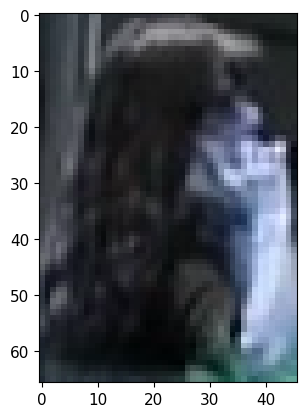

In [180]:
plt.imshow(a['cropped_img'][1])